# Реализовать синтезирование лиц из LFW с помощью DCGAN

# Библиотеки: [Python, Tensorflow]

## Libs

In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers

## Load data

In [2]:
(train_ds, test_ds), ds_info = tfds.load(
    name='lfw',
    as_supervised=True, with_info=True, 
    split=['train[:99%]', 'train[99%:]']
)

## View imgs

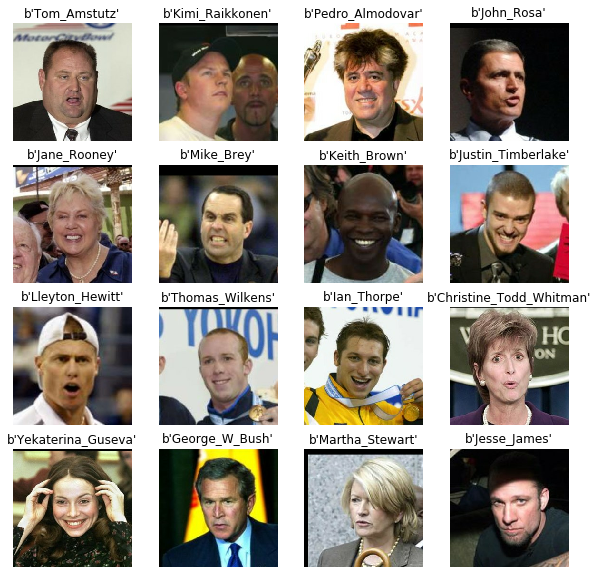

In [3]:
plt.figure(figsize=(10, 10))
for i, x in enumerate(train_ds.take(16)):
    plt.subplot(4, 4, i+1)
    plt.title(x[0].numpy())
    plt.imshow(x[1])
    plt.axis('off')

In [4]:
ex_lbl, ex_img = next(iter(train_ds.take(1)))
np.min(ex_img), np.max(ex_img), ex_img.shape

(0, 255, TensorShape([250, 250, 3]))

## Pipline imgs
Заресайзим картинки, что бы ускорить процесс обучения

In [5]:
BATCH_SIZE = 32
HALF_BATCH_SIZE = BATCH_SIZE // 2
EPOCHS = 1
IM_SIZE = 56

def prep_imgs(lbl, img):
    img = tf.cast(img, tf.float32) / 255
    img = tf.image.resize(img, (IM_SIZE, IM_SIZE))
    return lbl, img

train_ds = train_ds.map(prep_imgs)
train_ds = train_ds.repeat(EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

train_ds

<BatchDataset shapes: ((16,), (16, 56, 56, 3)), types: (tf.string, tf.float32)>

## Models

In [6]:
class Generator(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dns = layers.Dense(128*7*7, activation='relu')
        self.resh = layers.Reshape((7, 7, 128))
        self.ups = layers.UpSampling2D((2, 2))
        
        self.conv1 = layers.Conv2D(128, (3, 3), padding='same')
        self.conv2 = layers.Conv2D(64, (3, 3), padding='same')
        self.conv3 = layers.Conv2D(32, (3, 3), padding='same')
        
        self.conv0 = layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid')
        
        self.bnorm1 = layers.BatchNormalization(momentum=0.8)
        self.bnorm2 = layers.BatchNormalization(momentum=0.8)
        self.bnorm3 = layers.BatchNormalization(momentum=0.8)
        
        self.relu = layers.ReLU()
        
    def call(self, inp):
        out = self.dns(inp)
        out = self.resh(out)
        
        out = self.ups(out)
        out = self.conv1(out)
        out = self.bnorm1(out)
        out = self.relu(out)
        
        out = self.ups(out)
        out = self.conv2(out)
        out = self.bnorm2(out)
        out = self.relu(out)
        
        out = self.ups(out)
        out = self.conv3(out)
        out = self.bnorm3(out)
        out = self.relu(out)
        
        out = self.conv0(out)
        
        return out

In [7]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same')
        self.conv2 = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')
        self.conv3 = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')
        self.conv4 = layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')
        
        self.bnorm1 = layers.BatchNormalization(momentum=0.8)
        self.bnorm2 = layers.BatchNormalization(momentum=0.8)
        self.bnorm3 = layers.BatchNormalization(momentum=0.8)
        
        self.lrelu = layers.LeakyReLU(0.2)
        self.dout = layers.Dropout(0.25)
        self.zpadd = layers.ZeroPadding2D(padding=((0, 1), (0, 1)))
        self.fltn = layers.Flatten()
        self.dns = layers.Dense(1)
        
    def call(self, inp):
        out = self.conv1(inp)
        out = self.lrelu(out)
        out = self.dout(out)
        
        out = self.conv2(out)
        out = self.zpadd(out)
        out = self.bnorm1(out)
        out = self.lrelu(out)
        out = self.dout(out)
        
        out = self.conv3(out)
        out = self.bnorm2(out)
        out = self.lrelu(out)
        out = self.dout(out)
        
        out = self.conv4(out)
        out = self.bnorm3(out)
        out = self.lrelu(out)
        out = self.dout(out)
        
        out = self.fltn(out)
        out = self.dns(out)
        
        return out

## Prep to training

In [8]:
LEARNING_RATE = 0.0002
INPUT_DIM = 100

generator = Generator()
discriminator = Discriminator()

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Checkpoint

In [9]:
checkpoint_path = "./checkpoints2/train"

ckpt = tf.train.Checkpoint(
    generator=generator,
    discriminator=discriminator
)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!')

Latest checkpoint restored!


## Training

[Step 0] D Loss: 0.5872; G Loss: 1.7136


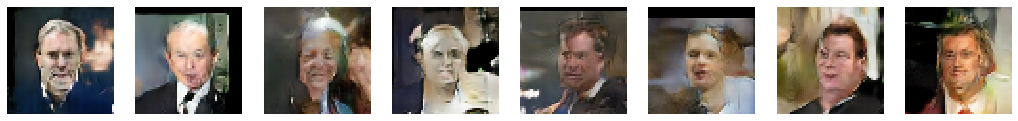

[Step 100] D Loss: 0.6127; G Loss: 1.0482


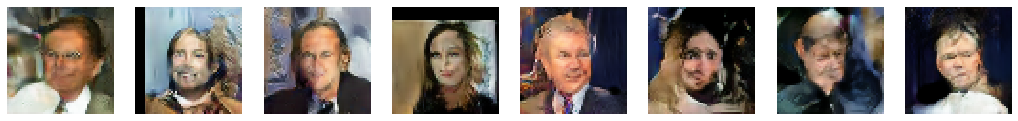

[Step 200] D Loss: 0.4593; G Loss: 1.6115


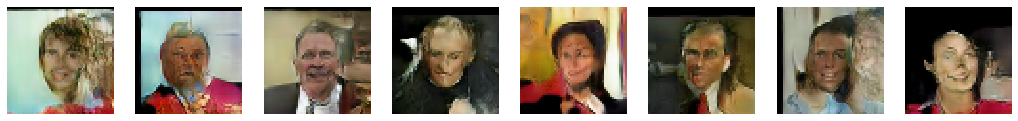

[Step 300] D Loss: 0.6712; G Loss: 1.3056


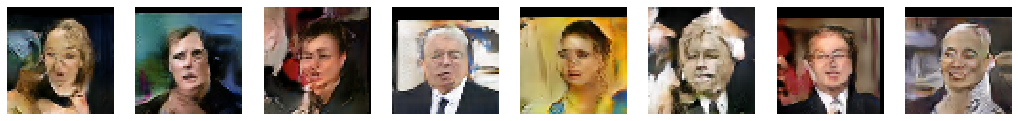

[Step 400] D Loss: 0.4219; G Loss: 1.9702


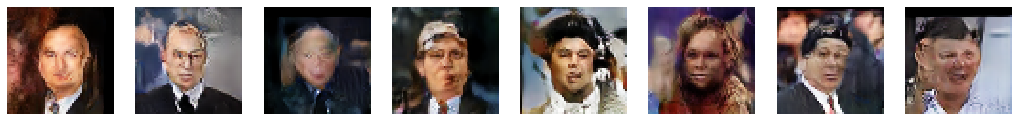

[Step 500] D Loss: 0.6309; G Loss: 1.4247


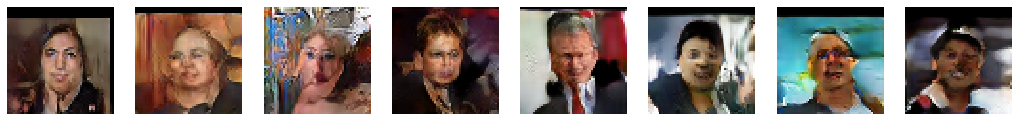

[Step 600] D Loss: 0.5435; G Loss: 2.0156


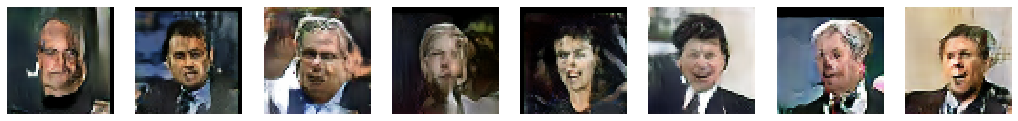

[Step 700] D Loss: 0.4540; G Loss: 1.8170


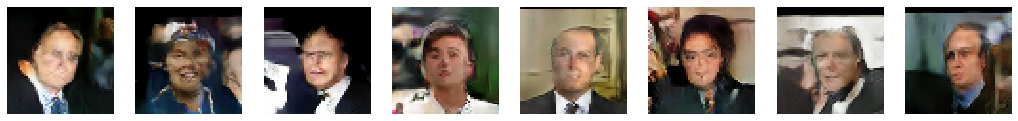

[Step 800] D Loss: 0.5727; G Loss: 1.8318


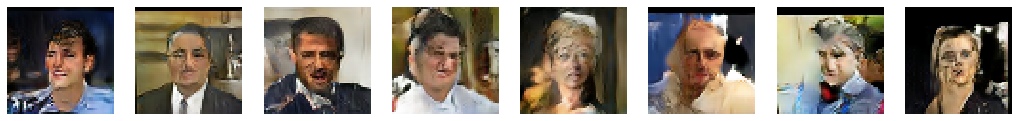

Wall time: 1min 19s


In [10]:
%%time

d_loss = []
g_loss = []

for step, (_, true_imgs) in enumerate(train_ds):

    # Train Discriminator

    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    gen_imgs = generator.predict(noise)

    x_comb = np.concatenate((
        true_imgs, 
        gen_imgs))
    y_comb = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))

    with tf.GradientTape() as tape:
        logs = discriminator(x_comb, training=True)
        d_loss_value = sigmoid_cross_entropy(y_comb, logs)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    d_loss.append(d_loss_value)
    
    # Train Generator

    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)

    with tf.GradientTape() as tape:
        gen_imgs = generator(noise, training=True)
        logs = discriminator(gen_imgs, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logs)

    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    g_loss.append(g_loss_value)

    if step % 100 == 0:
        d_loss.append(d_loss_value)
        g_loss.append(g_loss_value)
        
        print(f'[Step {step}] D Loss: {d_loss_value.numpy():.4f}; G Loss: {g_loss_value.numpy():.4f}')
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        gen_imgs = generator.predict(noise)
        plt.figure(figsize=(18, 2))
        for i in range(gen_imgs.shape[0]):
            plt.subplot(1, 8, i+1)
            plt.imshow(gen_imgs[i])
            plt.axis('off')
        plt.show()
        
        ckpt_manager.save()

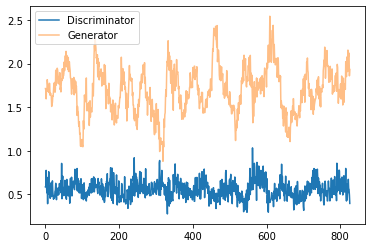

In [11]:
plt.plot(d_loss, label="Discriminator")
plt.plot(g_loss, label="Generator", alpha=0.5)
plt.legend()

## Resume

Очень интересно было наблюдать за формированием лиц, хотя часто выглядит это жутковато)<br>
Экспеименты с разными разрешениями картинок показали, что картинки с низким разрешением показывают не только более быструю скорость работы GAN, но и достигают результатов за меньшее число итераций.<br>
Данный результат произошо примерно спустя 600 эпох.